In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from geometry import *
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.patches import Circle
from scipy.spatial import Voronoi, voronoi_plot_2d

np.random.seed(0)

# FDE

We create a rotating squares diagram first assuming the centers of the squres are on the x and y axes. 
Then we do a series of rotations to get them aligned with how the toolpath was generated for Figure 1b

In [3]:
# Helper functions
def rotation_matrix(angle):
    """Create a 2D rotation matrix for the given angle in radians."""
    return np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])


def square_offset_distance(sl, angle):
    """
    Calculate offset distance between squares based on angle.
    This ensures squares touch at corners precisely.
    """
    return sl/np.sqrt(2) * (np.cos(angle/2) + np.sin(angle/2))

In [4]:
# Setup squares and grid

# Define figure bounds and grid parameters
x_min, x_max, y_min, y_max = -3., 3., -3., 3.  # Plotting region boundaries
dy = 0.2  # Vertical spacing between grid points
dx = 0.3  # Horizontal spacing between grid points

# Define square parameters
sl = 1  # Square side length

# Configuration for square placement and orientation
# 60 degrees - smaller of the two angle between adjacent squares
internal_angle = np.pi/3
# Distance between square centers and origin
dangle = square_offset_distance(sl, internal_angle)

# Create four squares in a cross pattern with alternating orientations
# Each square is given a different color to distinguish domains
squares = (
    # Top square (blue)
    SquareDomain(xy=(0., dangle),
                 side_length=sl,
                 facecolor='tab:blue',
                 edgecolor='k',
                 orientation=internal_angle,
                 alpha=0.5,
                 zorder=2),
    # Right square (orange)
    SquareDomain(xy=(dangle, 0.),
                 side_length=sl,
                 facecolor='tab:orange',
                 edgecolor='k',
                 orientation=-internal_angle,
                 alpha=0.5,
                 zorder=2),
    # Bottom square (green)
    SquareDomain(xy=(0., -dangle),
                 side_length=sl,
                 facecolor='tab:green',
                 edgecolor='k',
                 orientation=internal_angle,
                 alpha=0.5,
                 zorder=2),
    # Left square (red)
    SquareDomain(xy=(-dangle, 0.),
                 side_length=sl,
                 facecolor='tab:red',
                 edgecolor='k',
                 orientation=-internal_angle,
                 alpha=0.5,
                 zorder=2),
)

# Generate a background grid covering the entire domain
grid = Grid((x_min, x_max), (y_min, y_max), dx, dy, angle=0.)

# Set toolpath angle for the grid (60 degrees)
grid_angle = np.pi/3

# Rotate the squares to align with the grid angle
# We use -π/4 to account for the RegularPolygon default orientation in matplotlib
# and add grid_angle to match the orientation used in fabrication
for s in squares:
    # Rotate square position
    s.xy = rotation_matrix(-np.pi/4-grid_angle) @ s.xy
    # Adjust square orientation
    s.orientation -= np.pi/4 + grid_angle

# Create denser grids for each square domain to represent FDE toolpaths
# - Use tighter dx spacing to represent tighter coiling inside squares
# - Keep same dy spacing to match FDE layer height consistency
square_grids = []
for s in squares:
    # Create a dense grid with 10x horizontal density
    g = Grid((x_min, x_max), (y_min, y_max), dx/10, dy, angle=0.)
    # Filter points to only those inside the current square domain
    g.points = np.array([p for p in g.points if s.contains(p)])
    square_grids.append(g)

In [5]:
# Sanity check plot that overlays the grids (both for the global and squares) with the rotating squres diagram. Useful to help determine if our contains() method is working. Uncomment to check becasue matplotlib doesn't like to add the same square patches to different figures

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.set(aspect='equal')
# ax.axhline(0, color='k')
# ax.axvline(0, color='k')
# ax.set(xlim=(-2, 2), ylim=(-2, 2))


# for s in squares:
#     ax.add_patch(s)
#     # s.gridify(0.1, 0.1)
#     # ax.scatter(s.grid[:, 0], s.grid[:, 1])

# # Filter out points contained by any square
# filtered_points = [pt for pt in grid.points if not any(
#     s.contains(pt) for s in squares)]

# # Update grid points
# grid.points = np.array(filtered_points)

# grid.add_to_axes(ax, marker='.', color='k')
# for g in square_grids:
#     g.add_to_axes(ax, marker='.', color='r')

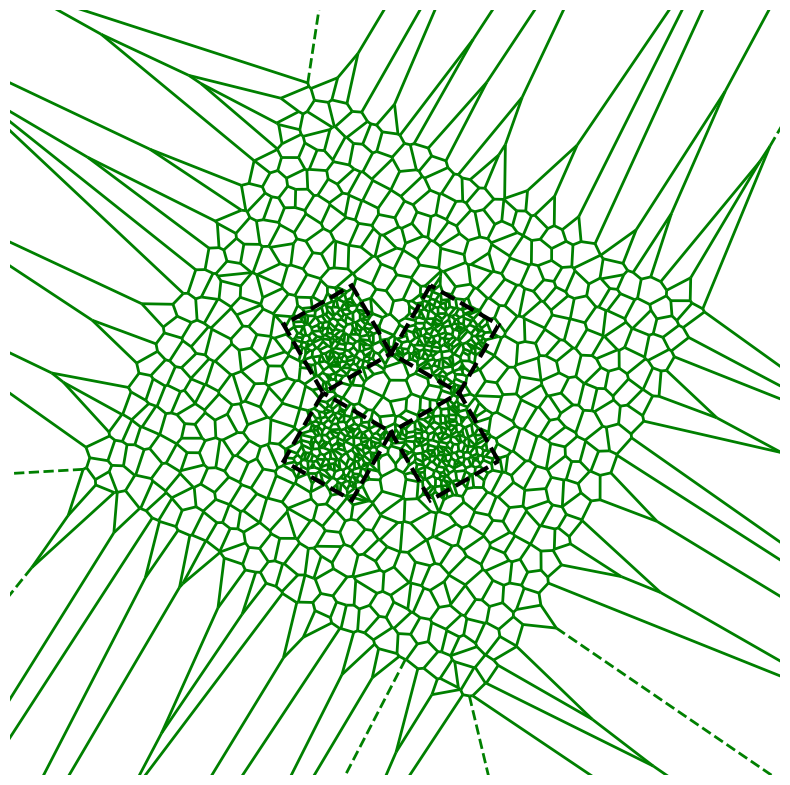

In [6]:
# Plot the FDE (Fabrication-Directed Entanglement) portion of Figure 1c
# This visualization shows a Voronoi tessellation of perturbed grid points
# representing the microstructure created by the FDE process

# Combine all grid points from the square domains and background grid
all_points = np.vstack([g.points for g in square_grids] + [grid.points])

# Apply controlled random perturbation to simulate material flow during printing
# ----------------------------------------------------------------------------
perturbation_radius = sl / 10.
# Generate random angles (0 to 2π) for each point
random_thetas = np.random.uniform(0., 2 * np.pi, size=all_points.shape[0])
# Generate random distances (0 to perturbation_radius) with square root distribution
# Square root gives uniform area distribution rather than radial distribution
random_radii = perturbation_radius * \
    np.sqrt(np.random.uniform(0., 1., size=all_points.shape[0]))
# Convert polar coordinates (r, θ) to Cartesian offsets (dx, dy)
dx = random_radii * np.cos(random_thetas)
dy = random_radii * np.sin(random_thetas)
# Apply the perturbation to all points
all_points += np.column_stack((dx, dy))

# Rotate the entire system to match the desired orientation for the figure
# ----------------------------------------------------------------------
rotation_angle = np.pi / 3  # 60 degrees rotation
rotation_matrix = np.array([
    [np.cos(rotation_angle), -np.sin(rotation_angle)],
    [np.sin(rotation_angle), np.cos(rotation_angle)]
])
all_points = all_points @ rotation_matrix.T

# Create Voronoi diagram from perturbed points and plot
# -------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))

vor = Voronoi(all_points)
voronoi_plot_2d(
    vor,
    ax=ax,
    show_points=False,
    show_vertices=False,
    line_width=2,
    line_colors='green'
)

# Update and add the square domain outlines to the plot
# ----------------------------------------------------
for s in squares:
    # Style the squares as dashed outlines to represent domain boundaries
    s.set(alpha=1, facecolor='None', lw=3, linestyle='--')
    # Apply the same rotation to the squares to match the point cloud
    s.orientation += rotation_angle
    s.xy = rotation_matrix @ s.xy
    # Add the square to the plot
    ax.add_patch(s)

# Finalize the plot
# ----------------
ax.set(aspect='equal')  # Preserve aspect ratio
ax.axis('off')          # Remove axes for cleaner visualization
plt.tight_layout()      # Adjust padding
# Save as SVG for publication-quality figure, we make it too big so we can crop it later
fig.savefig('images/fig1-fde.svg')

# Mesoscale Structure

In [7]:
def create_random_voronoi(n_points=1000, plot_bounds=[0, 1, 0, 1], save_path=None):
    """
    Create and visualize a Voronoi tessellation from randomly distributed points.

    This function generates a set of random points in 2D space, computes the
    Voronoi tessellation, and creates a visualization.

    Parameters:
    -----------
    n_points : int, default=1000
        Number of random points to generate for the Voronoi diagram
    plot_bounds : list, default=[0, 1, 0, 1]
        The bounds of the plot as [xmin, xmax, ymin, ymax]
    save_path : str, optional
        If provided, the plot will be saved to this file path

    Returns:
    --------
    fig : matplotlib Figure
        The figure containing the Voronoi diagram
    vor : scipy.spatial.Voronoi
        The Voronoi object containing the tessellation data
    """
    # Generate random points from a uniform distribution
    points = np.random.uniform(
        low=[plot_bounds[0], plot_bounds[2]],
        high=[plot_bounds[1], plot_bounds[3]],
        size=(n_points, 2)
    )

    # Compute Voronoi tessellation
    vor = Voronoi(points)

    # Create visualization
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot Voronoi diagram with green cell edges, no points or vertices
    voronoi_plot_2d(
        vor,
        ax=ax,
        show_points=False,  # Don't show the seed points
        show_vertices=False,  # Don't show Voronoi vertices
        line_width=2,  # Make lines thicker for visibility
        line_colors='green'  # Use green color for cell boundaries
    )

    # Set equal aspect ratio to ensure cells aren't distorted
    ax.set(aspect='equal')

    # Remove axes for cleaner visualization
    plt.axis('off')
    plt.tight_layout()

    # Save the figure if a path is provided
    if save_path:
        fig.savefig(save_path, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    return fig, vor

Figure saved to ./images/mesoscale.svg


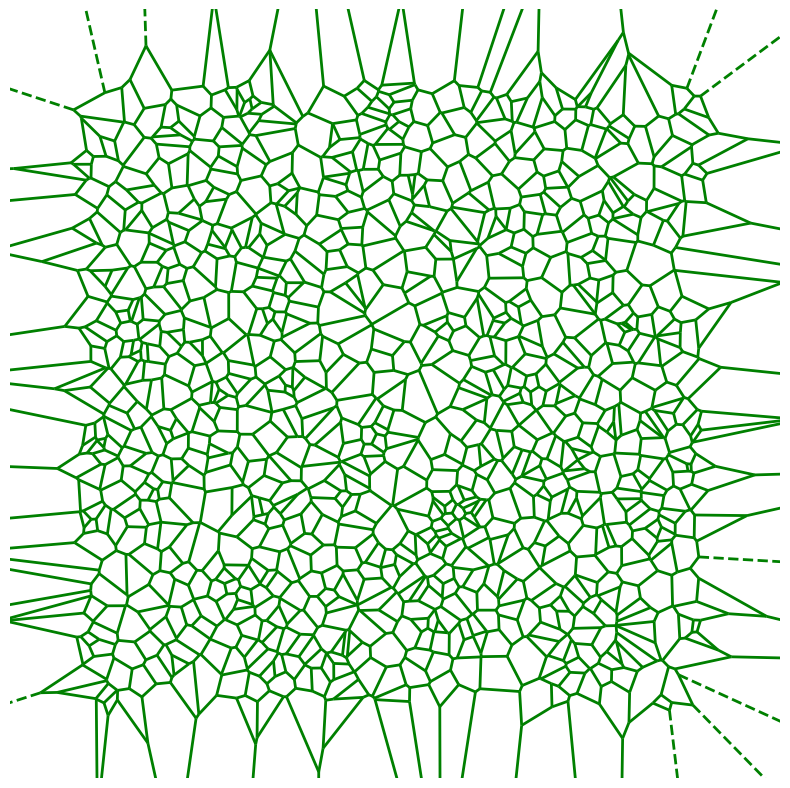

In [8]:
# Generate and save a Voronoi diagram as part of the mesoscale visualization.

fig, vor = create_random_voronoi(
    n_points=1000,
    save_path='./images/mesoscale.svg'
)